In [1]:
import polars as pl
from plotnine import *

In [2]:
with open('data/citibike/202403-citibike-tripdata.csv', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        print(line.rstrip())
        if i == 5:
            break

ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1B6974C51B5788DB,classic_bike,2024-03-14 18:31:26.739,2024-03-14 18:53:08.260,1 Ave & E 38 St,6230.02,W 76 St & Columbus Ave,7281.09,40.746202,-73.971822,40.7801839724239,-73.97728532552719,member
18FA2461899D63BD,classic_bike,2024-03-03 20:58:49.618,2024-03-03 21:19:58.899,Park Ave & E 124 St,7682.01,W 76 St & Columbus Ave,7281.09,40.8045555,-73.9396861,40.7801839724239,-73.97728532552719,member
19472F3D2F814B4A,electric_bike,2024-03-03 11:54:48.509,2024-03-03 12:11:19.163,W 34 St & Hudson Blvd E,6535.04,North Moore St & Greenwich St,5470.12,40.75516719072139,-74.00059908628464,40.72019521437465,-74.0103006362915,member
EE6390136F5EDF27,electric_bike,2024-03-05 11:37:20.593,2024-03-05 11:41:53.848,E 9 St & 5 Ave,5872.1,Ave A & E 11 St,5703.13,40.73275887045087,-73.99581670761108,40.72854745023944,-73.98175925016403,member
7F296

## Importar un csv con *polars*

In [3]:
trips = pl.read_csv(
    r"data\citibike\202403-citibike-tripdata.csv",
    try_parse_dates = True,
    schema_overrides={
        "start_station_id" : pl.String,
        "end_station_id" : pl.String
    },
).sort(
    "started_at"
)

In [4]:
print(trips[:, :4])
print(trips[:, 4:8])
print(trips[:, 8:])

shape: (2_663_295, 4)
┌──────────────────┬───────────────┬─────────────────────────┬─────────────────────────┐
│ ride_id          ┆ rideable_type ┆ started_at              ┆ ended_at                │
│ ---              ┆ ---           ┆ ---                     ┆ ---                     │
│ str              ┆ str           ┆ datetime[μs]            ┆ datetime[μs]            │
╞══════════════════╪═══════════════╪═════════════════════════╪═════════════════════════╡
│ 9EC2AD5F3F8C8B57 ┆ classic_bike  ┆ 2024-02-29 00:20:27.570 ┆ 2024-03-01 01:20:22.196 │
│ C76D82D96516BDC2 ┆ classic_bike  ┆ 2024-02-29 07:54:34.223 ┆ 2024-03-01 08:54:12.611 │
│ B4C73C958C65FEA6 ┆ electric_bike ┆ 2024-02-29 08:47:09.664 ┆ 2024-03-01 09:47:02.393 │
│ E23F7822B3D53E2A ┆ classic_bike  ┆ 2024-02-29 09:57:07.150 ┆ 2024-03-01 10:57:00.848 │
│ B0B6437C50C3AB3E ┆ electric_bike ┆ 2024-02-29 10:29:41.981 ┆ 2024-03-01 11:29:21.539 │
│ …                ┆ …             ┆ …                       ┆ …                       │

In [ ]:
!python -m json.tool data/citibike/nyc-neighborhoods.geojson

In [ ]:
neighborhoods = (pl.read_json("data/citibike/nyc-neighborhoods.geojson")
                 .select("features")
                 .explode("features")
                 .unnest("features")
                 .unnest("properties")
                 .select("neighborhood", "borough", "geometry")
                 .unnest("geometry")
                 .with_columns(polygon=pl.col("coordinates").list.first())
                 .select("neighborhood", "borough", "polygon")
                 .filter(pl.col("borough") != "Staten Island")  
                 .sort("neighborhood")
 )
neighborhoods

neighborhood,borough,polygon
str,str,list[list[f64]]
"""Allerton""","""Bronx""","[[-73.848597, 40.87167], [-73.845823, 40.870239], … [-73.848597, 40.87167]]"
"""Alley Pond Park""","""Queens""","[[-73.743333, 40.738883], [-73.743714, 40.739403], … [-73.743333, 40.738883]]"
"""Arverne""","""Queens""","[[-73.789535, 40.599972], [-73.789541, 40.599944], … [-73.789535, 40.599972]]"
"""Astoria""","""Queens""","[[-73.901603, 40.76777], [-73.902696, 40.766889], … [-73.901603, 40.76777]]"
"""Bath Beach""","""Brooklyn""","[[-73.99381, 40.60195], [-73.99962, 40.596469], … [-73.99381, 40.60195]]"
…,…,…
"""Williamsburg""","""Brooklyn""","[[-73.957572, 40.725097], [-73.952998, 40.722253], … [-73.957572, 40.725097]]"
"""Windsor Terrace""","""Brooklyn""","[[-73.980061, 40.660753], [-73.979878, 40.660711], … [-73.980061, 40.660753]]"
"""Woodhaven""","""Queens""","[[-73.86233, 40.695962], [-73.856544, 40.697075], … [-73.86233, 40.695962]]"


In [ ]:
# Agrega un índice de fila para cada barrio
neighborhoods_coords = (
    neighborhoods.with_row_index("id")
    # Explota la columna 'polygon' para obtener cada coordenada por separado
    .explode("polygon")
    # Extrae la longitud y latitud de cada punto del polígono
    .with_columns(
    lon=pl.col("polygon").list.first(),
    lat=pl.col("polygon").list.last(),
    )
    # Elimina la columna original de polígonos
    .drop("polygon")
    )

# Muestra el DataFrame resultante con coordenadas de cada barrio
neighborhoods_coords

id,neighborhood,borough,lon,lat
u32,str,str,f64,f64
0,"""Allerton""","""Bronx""",-73.848597,40.87167
0,"""Allerton""","""Bronx""",-73.845823,40.870239
0,"""Allerton""","""Bronx""",-73.854559,40.859954
0,"""Allerton""","""Bronx""",-73.854665,40.859586
0,"""Allerton""","""Bronx""",-73.856389,40.857594
…,…,…,…,…
257,"""Woodside""","""Queens""",-73.910618,40.755476
257,"""Woodside""","""Queens""",-73.90907,40.757565
257,"""Woodside""","""Queens""",-73.907828,40.756999


In [ ]:
stations = (
    trips.group_by(station=pl.col("start_station_name"))
    .agg(  
    lon=pl.col("start_lng").median(),
    lat=pl.col("start_lat").median(),
    )
    .sort("station")
    .drop_nulls()
 )

stations

station,lon,lat
str,f64,f64
"""1 Ave & E 110 St""",-73.9383,40.792327
"""1 Ave & E 16 St""",-73.981656,40.732219
"""1 Ave & E 18 St""",-73.980544,40.733812
"""1 Ave & E 30 St""",-73.975361,40.741444
"""1 Ave & E 38 St""",-73.971822,40.746202
…,…,…
"""Wyckoff Ave & Stanhope St""",-73.917775,40.703545
"""Wyckoff St & 3 Ave""",-73.982586,40.682755
"""Wythe Ave & Metropolitan Ave""",-73.963198,40.716887


findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font family 'Guardian Sans' not found.
findfont: Font famil

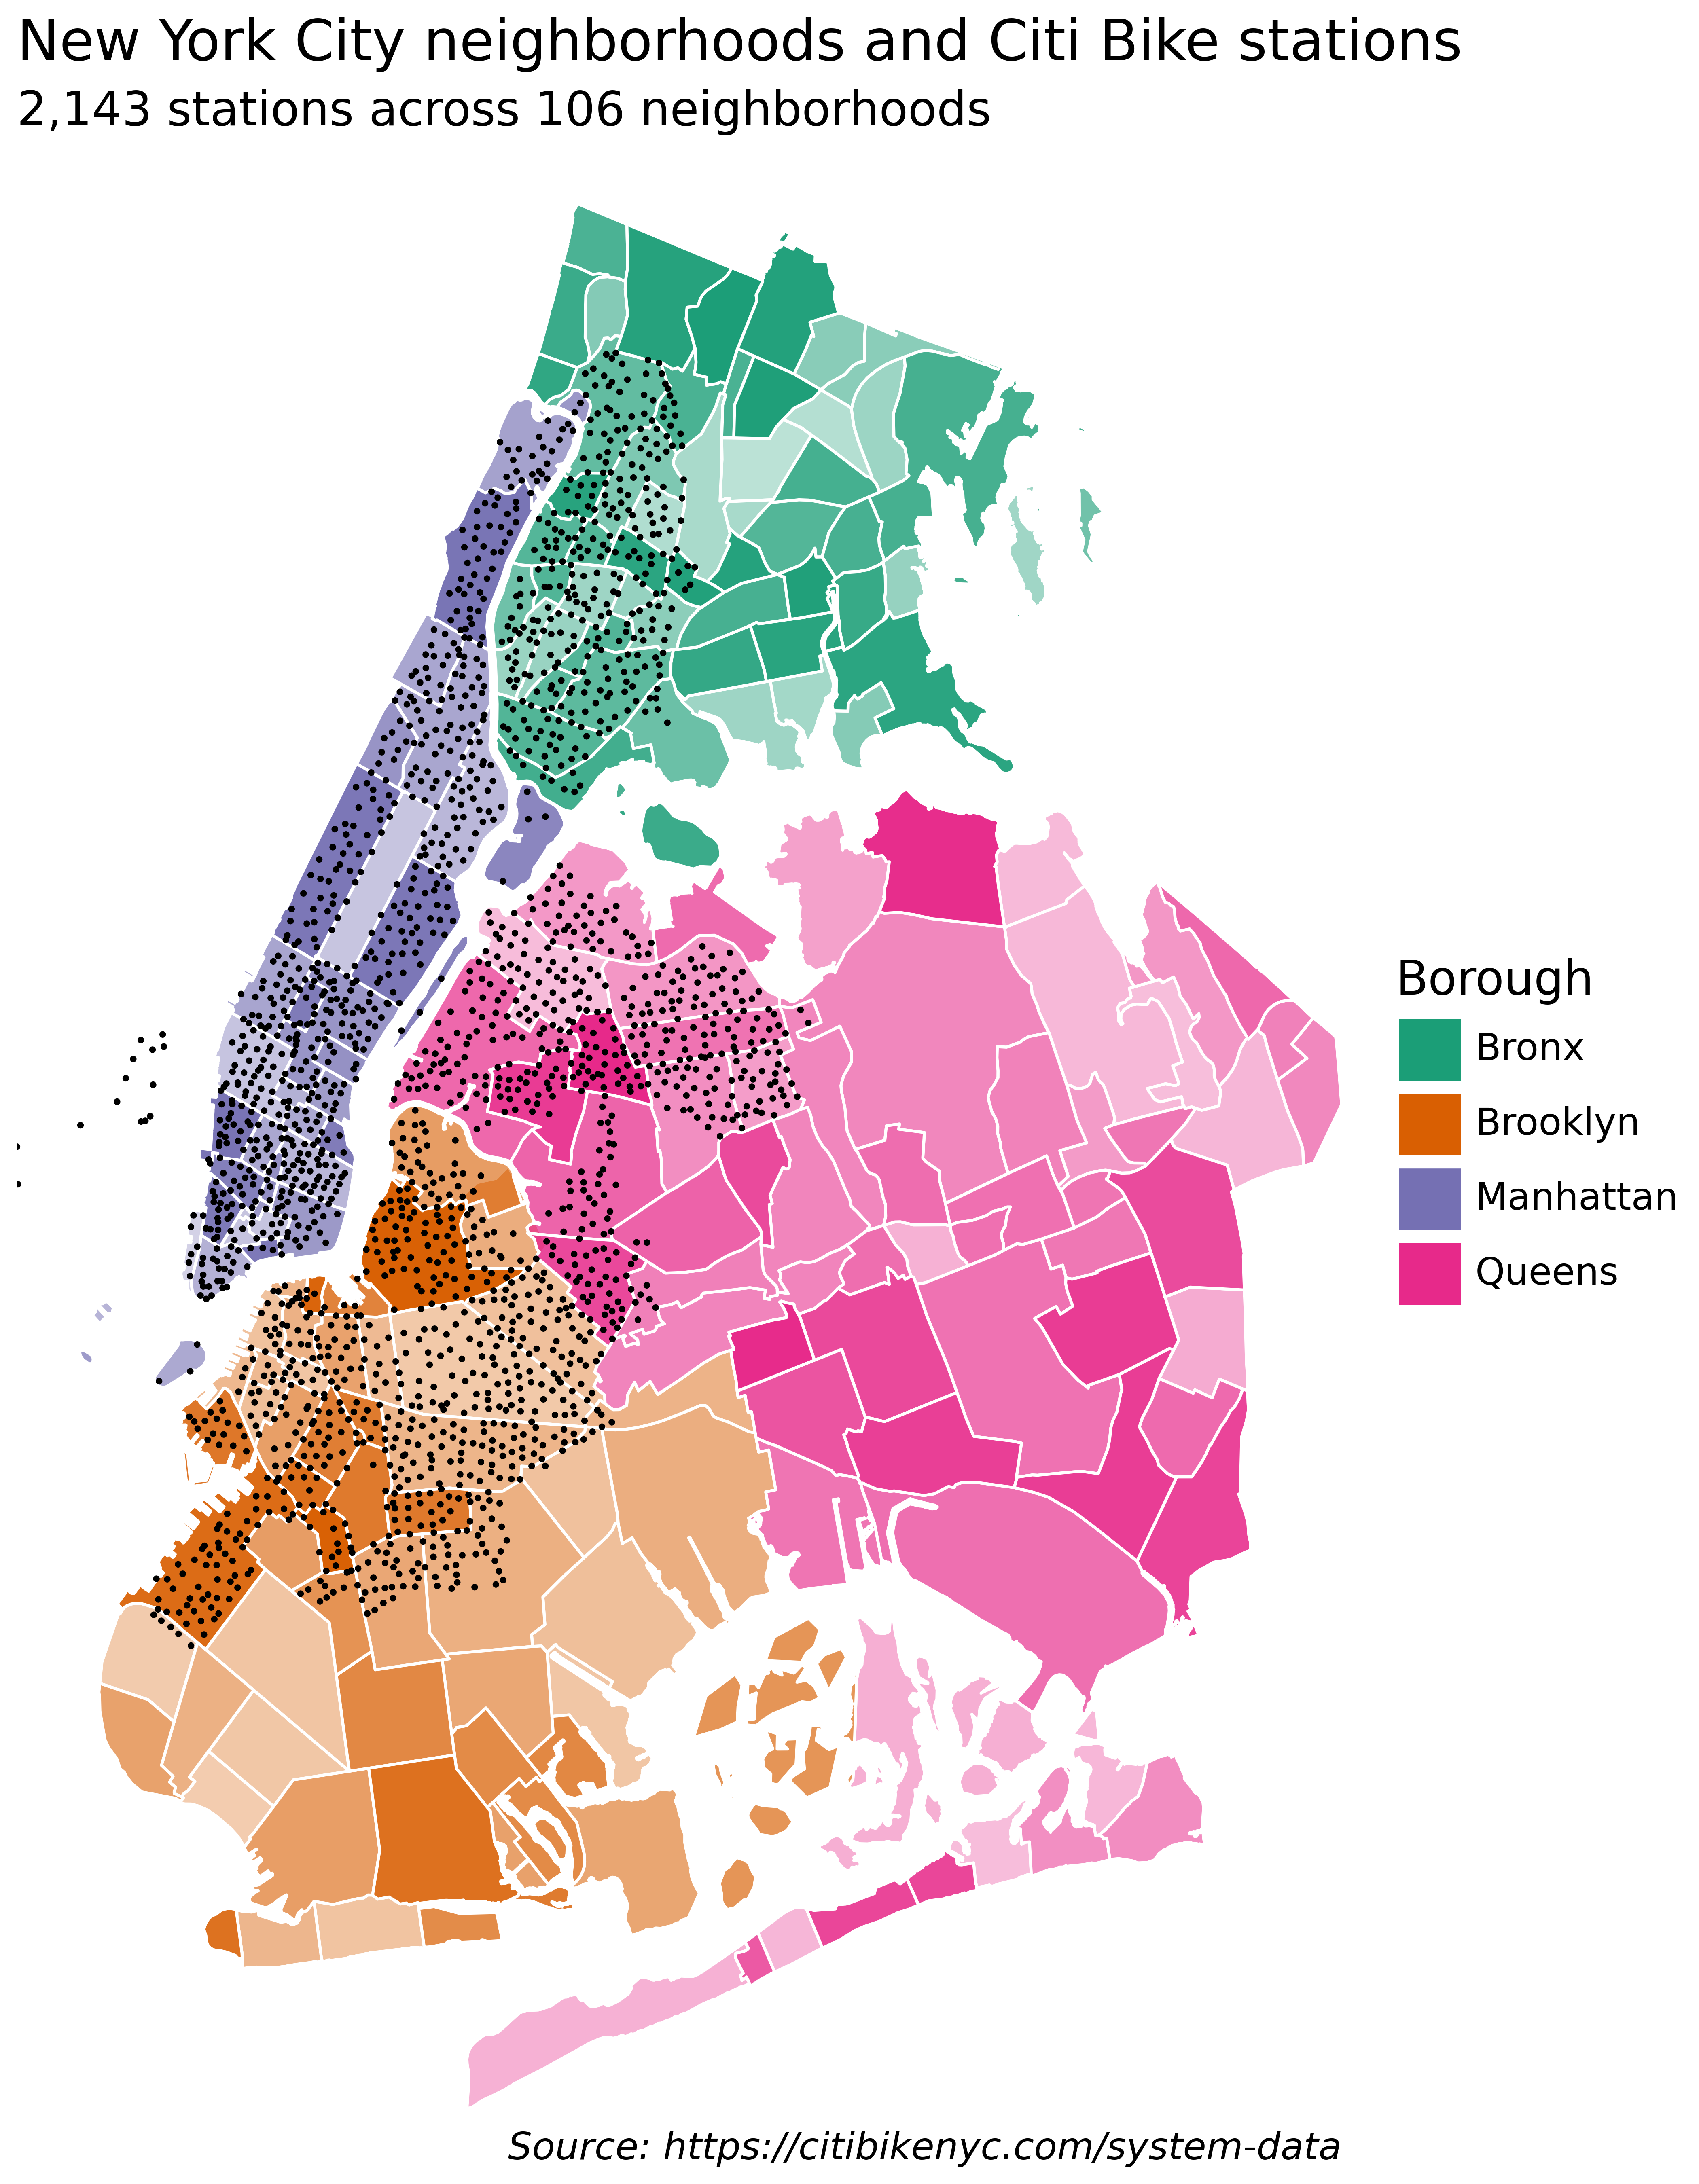

In [ ]:
(
    ggplot(neighborhoods_coords, aes(x="lon", y="lat", group="id"))
    + geom_polygon(aes(alpha="neighborhood", fill="borough"), color="white")
    + geom_point(stations, size=0.1)
    + scale_x_continuous(expand=(0, 0))
    + scale_y_continuous(expand=(0, 0, 0, 0.01))
    + scale_alpha_ordinal(range=(0.3, 1))
    + scale_fill_brewer(type="qual", palette=2)
    + guides(alpha=False)
    + labs(
    title="New York City neighborhoods and Citi Bike stations",
    subtitle="2,143 stations across 106 neighborhoods",
    caption="Source: https://citibikenyc.com/system-data",
    fill="Borough",
    )
    + theme_void(base_family="Guardian Sans", base_size=14)
    + theme(
    dpi=300,
    figure_size=(7, 9),
    plot_background=element_rect(fill="white", color="white"),
    plot_caption=element_text(style="italic"),
    plot_margin=0.01,
    plot_title=element_text(ha="left"),
 ))

In [ ]:
trips = trips.select(
    bike_type=pl.col("rideable_type")
    .str.split("_")
    .list.get(0)
    .cast(pl.Categorical),  
    rider_type=pl.col("member_casual").cast(pl.Categorical),
    datetime_start=pl.col("started_at"),
    datetime_end=pl.col("ended_at"),
    station_start=pl.col("start_station_name"),
    station_end=pl.col("end_station_name"),
    lon_start=pl.col("start_lng"),
    lat_start=pl.col("start_lat"),
    lon_end=pl.col("end_lng"),
    lat_end=pl.col("end_lat"),
    ).with_columns(  
    duration=(pl.col("datetime_end") - pl.col("datetime_start"))
 )
trips.columns

['bike_type',
 'rider_type',
 'datetime_start',
 'datetime_end',
 'station_start',
 'station_end',
 'lon_start',
 'lat_start',
 'lon_end',
 'lat_end',
 'duration']

In [ ]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    # Radio de la Tierra en km
    R = 6371.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

trips = trips.with_columns(
    distance=pl.struct(["lon_start", "lat_start", "lon_end", "lat_end"]).map_elements(
        lambda row: haversine(row["lon_start"], row["lat_start"], row["lon_end"], row["lat_end"])
    ).cast(pl.Float64)
)

trips.select(
    "lon_start",
    "lon_end",
    "lat_start",
    "lat_end",
    "distance",
    "duration",
)

C:\Users\sergi\AppData\Local\Temp\ipykernel_33040\1964112914.py:13: MapWithoutReturnDtypeWarning: 'return_dtype' of function python_udf must be set

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.
C:\Users\sergi\AppData\Local\Temp\ipykernel_33040\1964112914.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable radians method

In [ ]:
def point_in_polygon(point, polygon):
    # Ray casting algorithm for point-in-polygon
    x, y = point
    inside = False
    n = len(polygon)
    p1x, p1y = polygon[0]
    for i in range(n+1):
        p2x, p2y = polygon[i % n]
        if min(p1y, p2y) < y <= max(p1y, p2y) and x <= max(p1x, p2x):
            if p1y != p2y:
                xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
            if p1x == p2x or x <= xinters:
                inside = not inside
        p1x, p1y = p2x, p2y
    return inside

def assign_stations_to_neighborhoods(stations_df, neighborhoods_df):
    # Cross join and assign using map_elements
    return (
        stations_df.with_columns(point=pl.concat_list("lon", "lat"))
        .join(neighborhoods_df, how="cross")
        .with_columns(
            in_neighborhood=pl.struct(["point", "polygon"]).map_elements(
                lambda row: point_in_polygon(row["point"], row["polygon"])
            )
        )
        .filter(pl.col("in_neighborhood"))
        .unique("station")
        .select(
            "station",
            "borough",
            "neighborhood",
        )
    )

stations = assign_stations_to_neighborhoods(stations, neighborhoods)

stations

C:\Users\sergi\AppData\Local\Temp\ipykernel_33040\306083012.py:22: MapWithoutReturnDtypeWarning: 'return_dtype' of function python_udf must be set

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.
C:\Users\sergi\AppData\Local\Temp\ipykernel_33040\306083012.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


station,borough,neighborhood
str,str,str
"""1 Ave & E 110 St""","""Manhattan""","""East Harlem"""
"""1 Ave & E 16 St""","""Manhattan""","""Stuyvesant Town"""
"""1 Ave & E 18 St""","""Manhattan""","""Stuyvesant Town"""
"""1 Ave & E 30 St""","""Manhattan""","""Kips Bay"""
"""1 Ave & E 38 St""","""Manhattan""","""Murray Hill"""
…,…,…
"""Wyckoff Ave & Stanhope St""","""Brooklyn""","""Bushwick"""
"""Wyckoff St & 3 Ave""","""Brooklyn""","""Gowanus"""
"""Wythe Ave & Metropolitan Ave""","""Brooklyn""","""Williamsburg"""


In [ ]:
stations

station,borough,neighborhood
str,str,str
"""1 Ave & E 110 St""","""Manhattan""","""East Harlem"""
"""1 Ave & E 16 St""","""Manhattan""","""Stuyvesant Town"""
"""1 Ave & E 18 St""","""Manhattan""","""Stuyvesant Town"""
"""1 Ave & E 30 St""","""Manhattan""","""Kips Bay"""
"""1 Ave & E 38 St""","""Manhattan""","""Murray Hill"""
…,…,…
"""Wyckoff Ave & Stanhope St""","""Brooklyn""","""Bushwick"""
"""Wyckoff St & 3 Ave""","""Brooklyn""","""Gowanus"""
"""Wythe Ave & Metropolitan Ave""","""Brooklyn""","""Williamsburg"""


In [ ]:
trips = (
    trips.join(
        stations.select(pl.all().name.suffix("_start")), on="station_start"
    )
    .join(stations.select(pl.all().name.suffix("_end")), on="station_end")
    .select(
        "bike_type",
        "rider_type",
        "datetime_start",
        "datetime_end",
        "duration",
        "station_start",
        "station_end",
        "neighborhood_start",
        "neighborhood_end",
        "borough_start",
        "borough_end",
        "lat_start",
        "lon_start",
        "lat_end",
        "lon_end",
        "distance",
    )
 )

ColumnNotFoundError: unable to find column "neighborhood_start"; valid columns: ["bike_type", "rider_type", "datetime_start", "datetime_end", "station_start", "station_end", "lon_start", "lat_start", "lon_end", "lat_end", "duration", "lon_start_right", "lat_start_right", "lon_end_right", "lat_end_right"]

In [ ]:
print(trips[:, :4])
print(trips[:, 4:7])
print(trips[:, 7:11])
print(trips[:, 11:])

shape: (2_663_295, 4)
┌───────────┬────────────┬─────────────────────────┬─────────────────────────┐
│ bike_type ┆ rider_type ┆ datetime_start          ┆ datetime_end            │
│ ---       ┆ ---        ┆ ---                     ┆ ---                     │
│ cat       ┆ cat        ┆ datetime[μs]            ┆ datetime[μs]            │
╞═══════════╪════════════╪═════════════════════════╪═════════════════════════╡
│ classic   ┆ member     ┆ 2024-02-29 00:20:27.570 ┆ 2024-03-01 01:20:22.196 │
│ classic   ┆ member     ┆ 2024-02-29 07:54:34.223 ┆ 2024-03-01 08:54:12.611 │
│ electric  ┆ member     ┆ 2024-02-29 08:47:09.664 ┆ 2024-03-01 09:47:02.393 │
│ classic   ┆ member     ┆ 2024-02-29 09:57:07.150 ┆ 2024-03-01 10:57:00.848 │
│ electric  ┆ member     ┆ 2024-02-29 10:29:41.981 ┆ 2024-03-01 11:29:21.539 │
│ …         ┆ …          ┆ …                       ┆ …                       │
│ classic   ┆ member     ┆ 2024-03-31 23:55:37.938 ┆ 2024-03-31 23:59:08.301 │
│ classic   ┆ member     ┆ 202

In [ ]:
trips_per_hour = trips.group_by_dynamic(
 "datetime_start", group_by="borough_start", every="1d"
 ).agg(num_trips=pl.len())

trips_per_hour

ColumnNotFoundError: unable to find column "borough_start"; valid columns: ["bike_type", "rider_type", "datetime_start", "datetime_end", "station_start", "station_end", "lon_start", "lat_start", "lon_end", "lat_end", "duration"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["bike_type", "rider_type", "datetime_start", "datetime_end", ...]; PROJECT */11 COLUMNS

In [ ]:
from mizani.labels import label_comma
 
(
    ggplot(
        trips_per_hour,
        aes(x="datetime_start", y="num_trips", fill="borough_start"),
        )
        + geom_area()
        + scale_fill_brewer(type="qual", palette=2)
        + scale_x_datetime(date_labels="%-d", date_breaks="1 day", expand=(0, 0))
        + scale_y_continuous(labels=label_comma(), expand=(0, 0))
        + labs(
        x="March 2024",
        fill="Borough",
        y="Trips per day",
        title="Citi Bike trips per day in March 2024",
        subtitle="On March 23, nearly 10 cm of rain fell in NYC",
        )
        + theme_tufte(base_family="Guardian Sans", base_size=14)
        + theme(
        axis_ticks_major=element_line(color="white"),
        figure_size=(8, 5),
        legend_position="top",
        plot_background=element_rect(fill="white", color="white"),
        plot_caption=element_text(style="italic"),
        plot_title=element_text(ha="left"),
    )
)

NameError: name 'trips_per_hour' is not defined